# Getting Started

## Kernel functions

In [1]:
%load_ext autoreload
%autoreload 2

from lib.mesh import *
from lib.materials import*
from lib.assembly import StaticSolution,Solution

## List of variables

In [2]:
# This section will load user inputs and set global variables
# Not implemented yet
# Go to user inputs for desired test case as a temporary solution

# Placeholder
# Need to consider which variables are user inputs

# E4D files
# 1. file .inp
# 2. file .sig
# 3. file .cfg
# 4. file .inv (skip for sip)
# 5. file .out
# 6. file .srv

# Possible SIP files
# 1. file .inp (specifies run_mode: 1 for mesh generation; 2 for static solution; 3 for coupled solution)
# 2. file .hdf5 (stores mesh and material properties for domain equation and boundary equation)
# 3. file .cfg (will generate .poly for triangle; will be compatible with sphere/slab/membrane models)
# 4. file .out (specifies output options)
# 5. file .srv (specifies survey/external field options)

# print('='*80)
# %whos module
# print('='*80)
# %whos type
# print('='*80)
# %whos str
# print('='*80)
# %whos int
# print('='*80)
# %whos float
# print('='*80)
# %whos list
# print('='*80)
# %whos dict
# print('='*80)
# %whos ndarray matrix
# print('='*80)
# %whos function
%whos

Variable           Type        Data/Info
----------------------------------------
Air                type        <class 'lib.materials.Air'>
Consts             type        <class 'lib.materials.Consts'>
Dirichlet          type        <class 'lib.materials.Dirichlet'>
Domain             type        <class 'lib.materials.Domain'>
Flags              type        <class 'lib.mesh.Flags'>
Geometry           type        <class 'lib.mesh.Geometry'>
InnerBound         type        <class 'lib.materials.InnerBound'>
Mesh               type        <class 'lib.mesh.Mesh'>
OuterBound         type        <class 'lib.materials.OuterBound'>
PertubStern        type        <class 'lib.materials.PertubStern'>
Physics            type        <class 'lib.materials.Physics'>
Solid              type        <class 'lib.materials.Solid'>
Solution           type        <class 'lib.assembly.Solution'>
StaticDirichlet    type        <class 'lib.materials.StaticDirichlet'>
StaticDomain       type        <class 'lib.

# Example 1

In [41]:
from numpy.random import randint

class Cheese(object):
    def __init__(self, num_holes=0):
        "defaults to a solid cheese"
        self.number_of_holes = num_holes

    @classmethod
    def random(cls):
        return cls(randint(0, 100))

    @classmethod
    def slightly_holey(cls,**kwargs):
        return cls(randint(0, 33))

    @classmethod
    def very_holey(cls):
        return cls(randint(66, 100))

gouda = Cheese()
emmentaler = Cheese.random()
leerdammer = Cheese.slightly_holey()

## User inputs

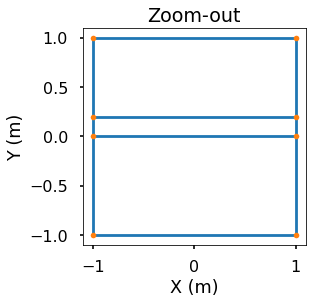

In [3]:
slab_geom = Geometry.build_slab(
    radius_air = 1.0, #radius of air
    height_air = 1.0, #height of air
    radius_water = 1.0, #radius of water
    height_water = 0.2, #height of water
    radius_solid = 1.0, #radius of solid
    height_solid = 1.0, #height of solid
    axis_symmetry = 'None', #X, or Y, or None
    )
slab_geom.visualize()

Opening slab_test.poly.
Constructing Delaunay triangulation by divide-and-conquer method.
Delaunay milliseconds:  0
Recovering segments in Delaunay triangulation.
Segment milliseconds:  0
Removing unwanted triangles.
Spreading regional attributes and area constraints.
Hole milliseconds:  0
Adding Steiner points to enforce quality.
Quality milliseconds:  6

Writing slab_test.1.node.
Writing slab_test.1.ele.
Writing slab_test.1.poly.
Writing slab_test.1.edge.
Writing slab_test.1.neigh.

Output milliseconds:  10
Total running milliseconds:  17

Statistics:

  Input vertices: 8
  Input segments: 8
  Input holes: 0

  Mesh vertices: 1319
  Mesh triangles: 2509
  Mesh edges: 3827
  Mesh exterior boundary edges: 127
  Mesh interior boundary edges: 64
  Mesh subsegments (constrained edges): 191

Reading slab_test.1.node
Reading slab_test.1.ele
Reading slab_test.1.edge

Computing shape functions of triangular elements
This will take a minute
Time elapsed  0.06506180763244629 sec

Computing shap

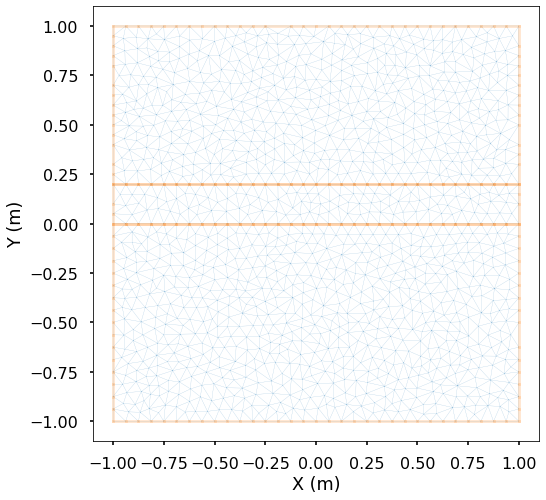

In [5]:
mesh = Mesh.build_mesh(
    prefix = 'slab_test',
    triangle = 'triangle',
    cpts = slab_geom.cpts,
    segs = slab_geom.segs,
    holes = slab_geom.holes,
    zones = slab_geom.zones,
    axis_symmetry = slab_geom.axis_symmetry
    )
mesh.visualize()

In [3]:
#modify user inputs in this block only
mesh_prefix = 'slab_2d'
triangle_path = 'triangle'

slab_geom = Geometry.build_slab(
    radius_air = 1.0, #radius of air
    height_air = 1.0, #height of air
    radius_water = 1.0, #radius of water
    height_water = 0.2, #height of water
    radius_solid = 1.0, #radius of solid
    height_solid = 1.0, #height of solid
    axis_symmetry = 'None', #X, or Y, or None
    )

slab_phys = Physics(
    c_ion = [1.0,1.0], #ion concentration at infinity [mol/m^3]
    z_ion = [-1.0,1.0], #ion valence or charge number [SI]
    mu_a = [5e-8,5e-8], #ion mobility in electrolyte [m^2/(Vs)]
    mu_s = 5e-9, #ion mobility in solid [m^2/(Vs)]
    rel_perm_a = 80.0, #relative permittivity of electrolyte [SI]
    rel_perm_i = 4.5, #relative permittivity of solid [SI]
    sigma_solid = -0.01, #surface charge density for solid [C]
    temperature = 293.0, #ambient temperature [K]
    is_solid_metal = False, #True if solid is metal otherwise false
    )

slab_srv = Survey(
    mode = [0], #run mode 0 for static; 1 for peturbation
    ratio = [0.0], #ratio of sigma_stern to sigma_solid [SI]
    freq = [0.0], #frequency used for perturbation solution [Hz]
    e_0 = [0.0,0.0], #Ex/Ey at infinity
    f_0 = [[0.0,0.0,0.0]], #x/y/charge density at point sources
    s_0 = 0.0, #voltage on equipotential surface
    )

#customize material properties below
def f_n(x,y,*args):
    dist = np.sqrt(x**2+y**2)
    f_n = np.zeros_like(dist)
    mask = dist>0
    f_n[mask] = np.pi/2.0*(1/dist[mask]*np.sin(np.pi*dist[mask]/2.0)
                         +np.pi/2.0*np.cos(np.pi*dist[mask]/2.0))
    f_n[~mask] = np.pi/2.0*(np.pi/2.0+np.pi/2.0)
    return f_n


def s_n(x,y,*args):        
    dist = np.sqrt(x**2+y**2)
    s_n = np.cos(np.pi*dist/2.0)
    return s_n

slab_air = Air(
    c_x = [[1.0]],
    c_y = [[1.0]],
    f_n = [f_n],
    )

slab_water = Water(
    c_x = [[1.0]],
    c_y = [[1.0]],
    f_n = [f_n],
    )

slab_solid = Solid(
    c_x = [[1.0]],
    c_y = [[1.0]],
    f_n = [f_n],
    )

slab_outer_bc = OuterBound(
    s_n = [s_n],
    )

#slab_inner_bc
#slab_stern
#slab_mixed_bc
print('Done')

Done


## Properties setup

Reading slab_2d.1.node
Reading slab_2d.1.ele
Reading slab_2d.1.edge

Computing shape functions of triangular elements
This will take a minute
Time elapsed  0.28781676292419434 sec

Computing shape functions of line segments
This will take a minute
Time elapsed  0.03859353065490723 sec

Assembling the system of equations for triangular elements
This will take a while
Time elapsed  1.205108642578125 sec

Incoorprating the boundary condition of the third kind
Time elapsed  0.2621281147003174 sec

Assembling the system of equations for triangular elements
This will take a while
Time elapsed  1.7330610752105713 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  0.036220550537109375 sec

Calling sparse linear system solver
Time elapsed  0.03957700729370117 sec

Computing fields and gradients in elements
Time elapsed  0.00279998779296875 sec



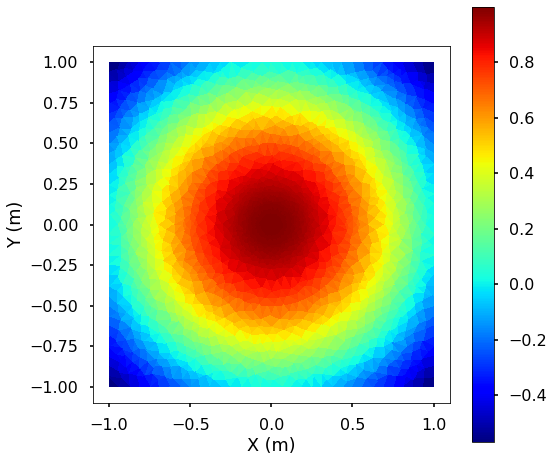

In [4]:
slab_mesh = Mesh.import_mesh(
    prefix = mesh_prefix,
    triangle = triangle_path,
    axis_symmetry = slab_geom.axis_symmetry,
    cpts = slab_geom.cpts,
    segs = slab_geom.segs,
    holes = slab_geom.holes,
    zones = slab_geom.zones,
    )

domain_stat = StaticDomain(slab_mesh,slab_phys,slab_srv)
robin_stat = StaticRobin(slab_mesh,slab_phys,slab_srv)
dirichlet_stat = StaticDirichlet(slab_mesh,slab_phys,slab_srv)

#run simulation
slab_stat = StaticSolution(slab_mesh,domain_stat,robin_stat,dirichlet_stat)
slab_mesh.tripcolor(slab_stat.sol)

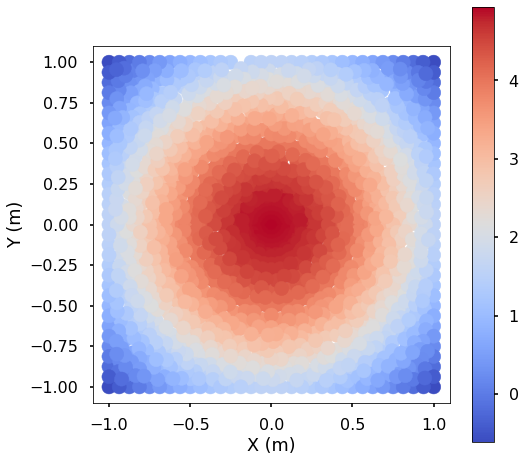

In [5]:
slab_mesh.scatter(domain_stat.f_n[:,0])

Computing fields and gradients in elements
Time elapsed  0.0036132335662841797 sec



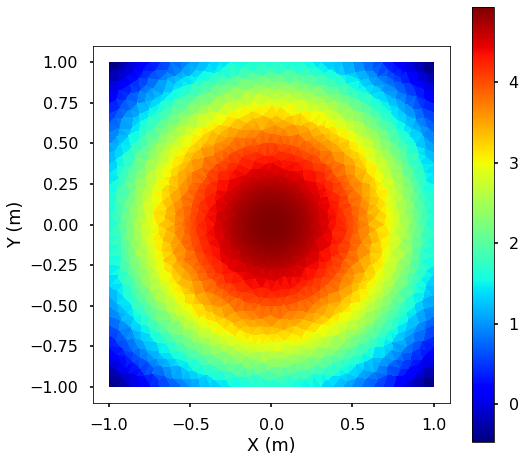

In [6]:
# slab_mesh.scatter(slab_mesh.is_on_outer_bound)
slab_mesh.tripcolor(domain_stat.f_n[:,0])

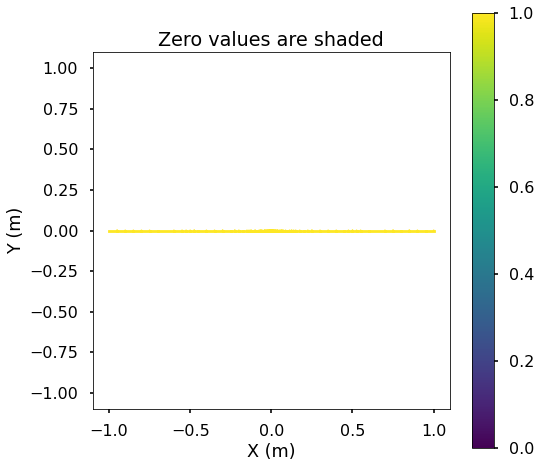

In [7]:
slab_mesh.plot(robin_stat.g_s[:,0])

## Static solution

Assembling the system of equations for triangular elements
This will take a while
Time elapsed  1.7634053230285645 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  0.03547096252441406 sec

Calling sparse linear system solver
Time elapsed  0.03932833671569824 sec

Computing fields and gradients in elements
Time elapsed  0.0038847923278808594 sec



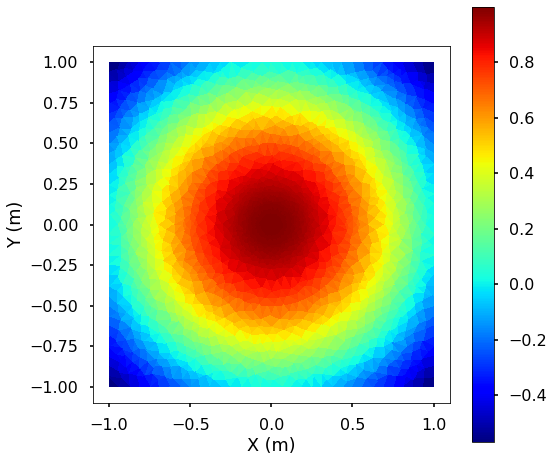

In [8]:
slab_stat = StaticSolution(slab_mesh,domain_stat,robin_stat,dirichlet_stat)
slab_mesh.tripcolor(slab_stat.sol)

Assembling the system of equations for triangular elements
This will take a while
Time elapsed  1.754345178604126 sec

Incoorprating the Dirichlet boundary condition
Time elapsed  0.034976959228515625 sec

Calling sparse linear system solver
Time elapsed  0.040442466735839844 sec

Computing fields and gradients in elements
Time elapsed  0.0018274784088134766 sec



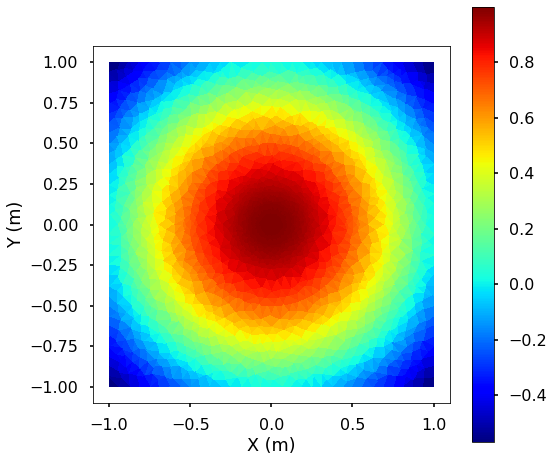

In [9]:
domain = Domain(slab_mesh,slab_air,slab_water,slab_solid)
dirichlet = Dirichlet(slab_mesh,slab_outer_bc)
sol = Solution(slab_mesh,domain,[],dirichlet)
slab_mesh.tripcolor(sol.sol)

## Psuedo-code

In [ ]:
run_simulation(model,survey)